# **QUESTION01**

In [1]:
import numpy as np
import random
import math

In [1]:
grid_size = 10
total_spaces = grid_size * grid_size
num_evs = 10
num_disabled = 5
num_regular = 35
total_cars = num_evs + num_disabled + num_regular
population_size = 100
generations = 20
tournament_size = 10
crossover_rate = 0.8
mutation_rate = 0.2

entrance = (5, 5)

charging_stations = [(1, 1), (2, 8), (5, 5), (7, 3), (9, 9)]


In [2]:
def index_to_coord(idx):
    idx = idx - 1
    row = idx // grid_size
    col = idx % grid_size
    return (row + 1, col + 1)

def coord_to_index(row, col):
    row = row - 1
    col = col - 1
    return row * grid_size + col + 1


In [4]:
reserved_spots = [coord_to_index(r, c) for r, c in charging_stations]
entrance_index = coord_to_index(entrance[0], entrance[1])
if entrance_index not in reserved_spots:
    reserved_spots.append(entrance_index)


In [5]:
import math

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def distance_to_nearest_charging_station(parking_spot):
    coord = index_to_coord(parking_spot)
    return min(euclidean_distance(coord, station) for station in charging_stations)

def distance_to_entrance(parking_spot):
    coord = index_to_coord(parking_spot)
    return euclidean_distance(coord, entrance)


In [6]:
import random

def generate_random_chromosome():
    available_spots = [i for i in range(1, total_spaces + 1) if i not in reserved_spots]
    if len(available_spots) < total_cars:
        raise ValueError(f"not enough available parking spots: {len(available_spots)} spots for {total_cars} cars")
    
    selected_spots = random.sample(available_spots, total_cars)
    return selected_spots


In [15]:
def initialize_population():
    return [generate_random_chromosome() for _ in range(population_size)]

In [7]:
def calculate_fitness(chromosome):
    total_distance = 0
    ev_penalty = 0
    disabled_penalty = 0
    
    for i, parking_spot in enumerate(chromosome):
        if i < num_evs:
            dist_to_station = distance_to_nearest_charging_station(parking_spot)
            if dist_to_station > 1.0:
                ev_penalty += dist_to_station * 5
            else:
                ev_penalty += dist_to_station * 2
        
        elif i < num_evs + num_disabled:
            dist_to_entrance = distance_to_entrance(parking_spot)
            if dist_to_entrance > 1.0:
                disabled_penalty += dist_to_entrance * 15
            else:
                disabled_penalty += dist_to_entrance * 5
        
        total_distance += distance_to_entrance(parking_spot)
    
    fitness = total_distance + ev_penalty + disabled_penalty
    
    return fitness


In [8]:
def tournament_selection(population, fitness_scores):
    selected = []
    
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        
        winner_idx = tournament_indices[tournament_fitness.index(min(tournament_fitness))]
        selected.append(population[winner_idx])
    
    return selected


In [10]:
def uniform_crossover(parent1, parent2):
    child = [None] * total_cars
    mask = [random.randint(0, 1) for _ in range(total_cars)]
    
    for i in range(total_cars):
        if mask[i] == 0:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    
    used_spots = set(child)
    all_spots = set(range(1, total_spaces + 1)) - set(reserved_spots)
    unused_spots = list(all_spots - used_spots)
    
    seen = set()
    for i in range(total_cars):
        if child[i] in seen or child[i] is None:
            if unused_spots:
                child[i] = unused_spots.pop()
        else:
            seen.add(child[i])
    
    return child


In [9]:
def swap_mutation(chromosome):
    if random.random() < mutation_rate:
        # Select two positions randomly
        pos1, pos2 = random.sample(range(total_cars), 2)
    
        chromosome[pos1], chromosome[pos2] = chromosome[pos2], chromosome[pos1]
    
    return chromosome

In [14]:
def genetic_algorithm():
    population = initialize_population()
    
    best_fitness = float('inf')
    best_chromosome = None
    best_fitness_streak = 0
    last_best_fitness = float('inf')
    generation = 0

    while True:
        fitness_scores = [calculate_fitness(chromosome) for chromosome in population]
        
        gen_best_idx = fitness_scores.index(min(fitness_scores))
        gen_best_fitness = fitness_scores[gen_best_idx]
        gen_best_chromosome = population[gen_best_idx]

        if gen_best_fitness < last_best_fitness:
            best_fitness_streak = 0
        else:
            best_fitness_streak += 1
        
        if best_fitness_streak >= 20:
            print(f"stopping early at generation {generation} due to no improvement in fitness for 20 consecutive generations.")
            break
        
        last_best_fitness = gen_best_fitness

        if gen_best_fitness < best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = gen_best_chromosome.copy()

        selected = tournament_selection(population, fitness_scores)

        new_population = []
        new_population.append(gen_best_chromosome)

        while len(new_population) < population_size:
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)

            if random.random() < crossover_rate:
                child = uniform_crossover(parent1, parent2)
            else:
                child = parent1.copy()

            child = swap_mutation(child)
            new_population.append(child)

        population = new_population

        print(f"generation {generation}: best fitness = {best_fitness}")
        generation += 1  
    
    return best_chromosome, best_fitness


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

color_map = {
    '.': 0,
    'c': 1,
    'e': 2,
    'x': 3,
    'v': 4,
    'd': 5,
    'r': 6
}

colors = ["white", "red", "blue", "purple", "green", "orange", "gray"]

def visualize_matrix(chromosome):
    matrix = [['.' for _ in range(grid_size)] for _ in range(grid_size)]
    
    for station in charging_stations:
        i, j = station
        matrix[i-1][j-1] = 'c'
    
    entrance_i, entrance_j = entrance
    if entrance not in charging_stations:
        matrix[entrance_i-1][entrance_j-1] = 'e'
    else:
        matrix[entrance_i-1][entrance_j-1] = 'x'
    
    for i, spot in enumerate(chromosome):
        row, col = index_to_coord(spot)
        if matrix[row-1][col-1] != '.':
            continue
        
        if i < num_evs:
            matrix[row-1][col-1] = 'v'
        elif i < num_evs + num_disabled:
            matrix[row-1][col-1] = 'd'
        else:
            matrix[row-1][col-1] = 'r'
    
    print("\nparking layout:")
    print("c = charging station, e = entrance, x = both, v = electric vehicle, d = disabled, r = regular, . = empty")
    print("  " + "".join([f" {i} " for i in range(1, grid_size + 1)]))
    for i in range(grid_size):
        print(f"{i+1} ", end="")
        for j in range(grid_size):
            print(f"[{matrix[i][j]}]", end="")
        print()
    
    heatmap = np.array([[color_map[cell] for cell in row] for row in matrix])
    
    fig, ax = plt.subplots()
    cax = ax.matshow(heatmap, cmap=plt.cm.get_cmap('tab10', len(colors)))
    
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_xticklabels(range(1, grid_size + 1))
    ax.set_yticklabels(range(1, grid_size + 1))
    
    legend_elements = [Line2D([0], [0], marker='s', color='w', markersize=10, markerfacecolor=colors[i], label=list(color_map.keys())[i]) for i in range(len(colors))]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.title("parking lot heatmap")
    plt.show()


Starting Genetic Algorithm for Car Parking Optimization...
Reserved spots (charging stations and entrance): [1, 18, 45, 63, 89]
generation 0: best fitness = 392.2510911353004
generation 1: best fitness = 391.94193123380205
generation 2: best fitness = 376.9345363424417
generation 3: best fitness = 360.91896177090916
generation 4: best fitness = 344.79381157231336
generation 5: best fitness = 324.0700756366545
generation 6: best fitness = 316.25867064507884
generation 7: best fitness = 313.3310729803517
generation 8: best fitness = 311.6873641500983
generation 9: best fitness = 310.95543176884576
generation 10: best fitness = 310.95543176884576
generation 11: best fitness = 310.85641225525296
generation 12: best fitness = 310.85641225525296
generation 13: best fitness = 305.7853444433875
generation 14: best fitness = 305.7853444433875
generation 15: best fitness = 305.7853444433875
generation 16: best fitness = 305.7853444433875
generation 17: best fitness = 305.7853444433875
generation

C:\Users\Hp\AppData\Local\Temp\ipykernel_14536\3567019188.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cax = ax.matshow(heatmap, cmap=plt.cm.get_cmap('tab10', len(colors)))


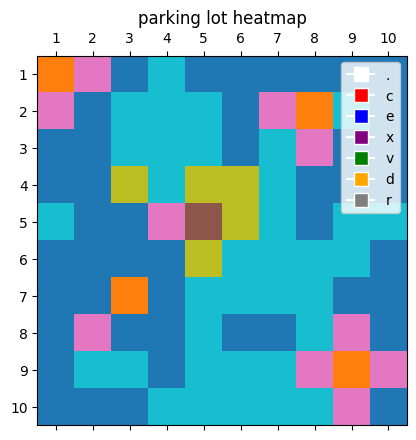


Best fitness: 271.49958764613


In [16]:
def main():
    print("Starting Genetic Algorithm for Car Parking Optimization...")
    print(f"Reserved spots (charging stations and entrance): {reserved_spots}")
    
    best_chromosome, best_fitness = genetic_algorithm()
    print("\nBest Chromosome (Parking Spots Assignment):")
    print(best_chromosome)
    
    visualize_matrix(best_chromosome)
    
    print(f"\nBest fitness: {best_fitness}")

if __name__ == "__main__":
    main()

# **QUESTION02**

In [54]:
import random
import numpy as np

In [55]:
#trading strategies
data = {
    "S1": {"return": 0.5, "risk": 1, "drawdown": -1},
    "S2": {"return": 1.2, "risk": 2, "drawdown": -2.5},
    "S3": {"return": 2.5, "risk": 3, "drawdown": -5},
    "S4": {"return": 5, "risk": 4, "drawdown": -10},
    "S5": {"return": 10, "risk": 5, "drawdown": -15},
}
strategies = list(data.keys())

In [56]:
def generate_chromosome():
    chromosome = [random.choice(strategies)]
    for _ in range(29):
        valid_choices = [s for s in strategies if s != chromosome[-1]]
        chromosome.append(random.choice(valid_choices))
    return chromosome

In [57]:
def fitness(chromosome):
    total_return, cumulative_drawdown, penalties = 0, 0, 0
    
    for i, strategy in enumerate(chromosome):
        total_return += data[strategy]["return"]
        cumulative_drawdown += data[strategy]["drawdown"]
        
        if i > 0 and chromosome[i] == chromosome[i - 1]:
            penalties += 5  
        
        if data[strategy]["drawdown"] < -15:
            penalties += 10  
    
    if cumulative_drawdown < -30:
        penalties += 20  
    
    return total_return - penalties

In [58]:
def tournament_selection(population, k=5):
    selected = random.sample(population, k)
    return sorted(selected, key=lambda x: fitness(x), reverse=True)[:2]


def crossover(parent1, parent2):
    point = random.randint(1, 28)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(chromosome):
    for i in range(len(chromosome)):
        if random.random() < 0.05:
            valid_choices = [s for s in strategies if s != chromosome[i]]
            chromosome[i] = random.choice(valid_choices)
    return chromosome

In [59]:
def genetic_algorithm(generations=100, population_size=100):
    population = [generate_chromosome() for _ in range(population_size)]
    
    for _ in range(generations):
        population = sorted(population, key=lambda x: fitness(x), reverse=True)
        new_population = population[:population_size // 2]
        
        while len(new_population) < population_size:
            parent1, parent2 = tournament_selection(population)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1), mutate(child2)])
        
        population = new_population[:population_size]
    
    best_strategy = max(population, key=lambda x: fitness(x))
    total_drawdown = sum(data[name]['drawdown'] for name in best_strategy)
    daily_fluctuations = [data[name]['drawdown'] for name in best_strategy]
    max_drawdown = min(daily_fluctuations)  # Most negative drawdown spike
    avg_drawdown = total_drawdown / len(daily_fluctuations)  # Average drawdown
    
    return best_strategy, fitness(best_strategy), total_drawdown, daily_fluctuations, max_drawdown, avg_drawdown

In [61]:

best_strategy, best_profit, total_drawdown, daily_fluctuations, max_drawdown, avg_drawdown = genetic_algorithm()


print("Best 30-day strategy sequence:", best_strategy)
print("Total profit after 30 days:", best_profit)
print("Total drawdown:", total_drawdown)
print("Daily drawdown fluctuations:", daily_fluctuations)
print("Max drawdown spike:", max_drawdown)
print("Average daily drawdown:", avg_drawdown)

Best 30-day strategy sequence: ['S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5', 'S4', 'S5']
Total profit after 30 days: 205
Total drawdown: -380
Daily drawdown fluctuations: [-15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15, -15, -10, -15, -10, -15, -10, -15, -10, -15, -10, -15]
Max drawdown spike: -15
Average daily drawdown: -12.666666666666666


In [ ]:
# import random

# def generate_chromosome():
#     chromosome = [random.choice(list(strategies.keys()))]
#     for _ in range(29):
#         valid_choices = [s for s in strategies if s != chromosome[-1]]
#         chromosome.append(random.choice(valid_choices))
#     return chromosome

# def fitness(chromosome):
#     total_return, cumulative_drawdown, penalties = 0, 0, 0
    
#     for i, strategy_name in enumerate(chromosome):
#         strategy = strategies[strategy_name]
#         total_return += strategy['return']
#         cumulative_drawdown += strategy['drawdown']
        
#         if i > 0 and chromosome[i] == chromosome[i - 1]:
#             penalties += 5
        
#         if strategy['drawdown'] < -15:
#             penalties += 10
    
#     if cumulative_drawdown < -30:
#         penalties += 20
    
#     return total_return - penalties

# def tournament_selection(population, k=5):
#     selected = random.sample(population, k)
#     return max(selected, key=fitness)

# def crossover(parent1, parent2):
#     point = random.randint(1, 28)
#     return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# def mutate(chromosome):
#     if random.random() < 0.05:
#         idx = random.randint(0, 29)
#         valid_choices = [s for s in strategies if s != chromosome[idx]]
#         chromosome[idx] = random.choice(valid_choices)
#     return chromosome

# def genetic_algorithm(generations=100, population_size=100):
#     population = [generate_chromosome() for _ in range(population_size)]
    
#     for generation in range(generations):
#         population = sorted(population, key=fitness, reverse=True)
#         best_fitness = fitness(population[0])
#         print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")
        
#         new_population = population[:population_size // 2]
        
#         while len(new_population) < population_size:
#             parent1, parent2 = tournament_selection(population), tournament_selection(population)
#             child1, child2 = crossover(parent1, parent2)
#             new_population.extend([mutate(child1), mutate(child2)])
        
#         population = new_population[:population_size]
    
#     best_strategy = max(population, key=fitness)
#     total_drawdown = sum(strategies[name]['drawdown'] for name in best_strategy)
#     daily_fluctuations = [strategies[name]['drawdown'] for name in best_strategy]
    
#     return best_strategy, fitness(best_strategy), total_drawdown, daily_fluctuations

# strategies = {
#     "S1": {"return": 0.5, "risk": 1, "drawdown": -1},
#     "S2": {"return": 1.2, "risk": 2, "drawdown": -2.5},
#     "S3": {"return": 2.5, "risk": 3, "drawdown": -5},
#     "S4": {"return": 5, "risk": 4, "drawdown": -10},
#     "S5": {"return": 10, "risk": 5, "drawdown": -15},
# }

# best_strategy, best_profit, total_drawdown, daily_fluctuations = genetic_algorithm()
# print("Best 30-day strategy sequence:", best_strategy)
# print("Total profit after 30 days:", best_profit)
# print("Total drawdown:", total_drawdown)
# print("Daily drawdown fluctuations:", daily_fluctuations)

Generation 1: Best Fitness = 131.6
Generation 2: Best Fitness = 141.4
Generation 3: Best Fitness = 148.79999999999995
Generation 4: Best Fitness = 149.49999999999997
Generation 5: Best Fitness = 157.0
Generation 6: Best Fitness = 163.2
Generation 7: Best Fitness = 164.7
Generation 8: Best Fitness = 167.7
Generation 9: Best Fitness = 171.0
Generation 10: Best Fitness = 171.7
Generation 11: Best Fitness = 176.7
Generation 12: Best Fitness = 176.7
Generation 13: Best Fitness = 176.7
Generation 14: Best Fitness = 176.7
Generation 15: Best Fitness = 176.7
Generation 16: Best Fitness = 176.7
Generation 17: Best Fitness = 176.7
Generation 18: Best Fitness = 176.7
Generation 19: Best Fitness = 176.7
Generation 20: Best Fitness = 176.7
Generation 21: Best Fitness = 176.7
Generation 22: Best Fitness = 176.7
Generation 23: Best Fitness = 176.7
Generation 24: Best Fitness = 178.0
Generation 25: Best Fitness = 178.0
Generation 26: Best Fitness = 178.0
Generation 27: Best Fitness = 178.0
Generation 

# **Question03**

In [32]:
def initialize_grid():
    rows, cols = 3, 50
    mafia_percentage = 0.3
    start_pos = (2, 0)
    exit_pos = (0, 49)
    
    grid = np.zeros((rows, cols))
    total_blocks = rows * cols
    mafia_blocks = int(total_blocks * mafia_percentage)
    
    mafia_positions = set()
    while len(mafia_positions) < mafia_blocks:
        row = random.randint(0, rows - 1)
        col = random.randint(0, cols - 1)
        if (row, col) != start_pos and (row, col) != exit_pos:
            mafia_positions.add((row, col))
    
    for pos in mafia_positions:
        grid[pos[0]][pos[1]] = 1
    
    return grid

In [33]:
def is_valid_move(current_pos, action, grid):
    actions = {
        'forward': (0, 1), 'jump': (-1, 0),
        'step_down': (1, 0), 'super_jump': (-2, 0), 'dash': (0, 2)
    }
    
    row, col = current_pos
    row_change, col_change = actions[action]
    new_row = row + row_change
    new_col = col + col_change
    
    if not (0 <= new_row < 3 and 0 <= new_col < 50):
        return False
    if grid[new_row][new_col] == 1:
        return False
    return True

In [34]:
def fitness(individual, grid):
    start_pos = (2, 0)
    exit_pos = (0, 49)
    max_moves = 70
    current_pos = start_pos
    moves_taken = 0
    closest_distance = abs(exit_pos[0] - start_pos[0]) + abs(exit_pos[1] - start_pos[1])
    
    for move in individual:
        if is_valid_move(current_pos, move, grid):
            row_change, col_change = {
                'forward': (0, 1), 'jump': (-1, 0),
                'step_down': (1, 0), 'super_jump': (-2, 0), 'dash': (0, 2)
            }[move]
            current_pos = (current_pos[0] + row_change, current_pos[1] + col_change)
            moves_taken += 1
            
            current_distance = abs(exit_pos[0] - current_pos[0]) + abs(exit_pos[1] - current_pos[1])
            closest_distance = min(closest_distance, current_distance)
            
            if current_pos == exit_pos:
                return 10000 + (max_moves - moves_taken) * 10, True
        else:
            break
    
    # Reward getting closer to exit and penalize moves
    return 5000 - closest_distance * 50 - moves_taken, False

In [35]:
def generate_individual():
    actions = ['forward', 'jump', 'step_down', 'super_jump', 'dash']
    weighted_actions = ['forward'] * 4 + ['dash'] * 3 + ['jump'] * 2 + ['super_jump'] + ['step_down']
    return [random.choice(weighted_actions) for _ in range(70)]

In [36]:
def initialize_population(population_size):
    return [generate_individual() for _ in range(population_size)]

In [37]:
def selection(population, grid, elite_size=3):
    fitness_results = [fitness(ind, grid) for ind in population]
    fitness_scores = [result[0] for result in fitness_results]
    
    #elitism
    elite_indices = np.argsort(fitness_scores)[-elite_size:]
    elite = [population[i].copy() for i in elite_indices]
    
    tournament_size = 5
    selected = elite.copy()
    
    while len(selected) < len(population):
        tournament = random.sample(population, tournament_size)
        winner = max(tournament, key=lambda x: fitness(x, grid)[0])
        selected.append(winner.copy())
    
    return selected

In [38]:
def crossover(parent1, parent2):
    point = random.randint(0, 69)
    return parent1[:point] + parent2[point:]

def mutation(individual, mutation_rate=0.05):
    actions = ['forward', 'jump', 'step_down', 'super_jump', 'dash']
    weighted_actions = ['forward'] * 4 + ['dash'] * 3 + ['jump'] * 2 + ['super_jump'] + ['step_down']
    return [move if random.random() >= mutation_rate else random.choice(weighted_actions) 
            for move in individual]

In [39]:
def run_simulation(generations=300, population_size=50):
    grid = initialize_grid()
    population = initialize_population(population_size)
    best_fitness = float('-inf')
    best_individual = None
    reached_exit = False
    
    for gen in range(generations):
        fitness_results = [fitness(ind, grid) for ind in population]
        fitness_scores = [result[0] for result in fitness_results]
        success_flags = [result[1] for result in fitness_results]
        
        current_best_idx = fitness_scores.index(max(fitness_scores))
        current_best_fitness = fitness_scores[current_best_idx]
        current_reached_exit = success_flags[current_best_idx]
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[current_best_idx].copy()
            reached_exit = current_reached_exit
        
        # Track final position of best individual
        pos = (2, 0)
        for move in population[current_best_idx]:
            if is_valid_move(pos, move, grid):
                row_change, col_change = {
                    'forward': (0, 1), 'jump': (-1, 0),
                    'step_down': (1, 0), 'super_jump': (-2, 0), 'dash': (0, 2)
                }[move]
                pos = (pos[0] + row_change, pos[1] + col_change)
            else:
                break
        
        print(f"\nGeneration {gen}:")
        print(f"Best Fitness: {current_best_fitness}")
        print(f"Reached Exit: {current_reached_exit}")
        print(f"Final Position: {pos}")
        print(f"Best Strategy (first 20 moves): {population[current_best_idx][:20]}")
        
        if current_reached_exit:
            print(f"\nSolution found in generation {gen}!")
            print(f"Final Best Strategy: {best_individual}")
            break
            
        selected = selection(population, grid)
        next_population = []
        
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            child = crossover(parent1, parent2)
            child = mutation(child)
            next_population.append(child)
        
        population = next_population
    
    return best_individual, best_fitness, reached_exit, grid

In [41]:
if __name__ == "__main__":
    best_solution, best_score, reached_exit, grid = run_simulation()
    print(f"\nFinal Best Fitness: {best_score}")
    print(f"Reached Exit: {reached_exit}")
    print(f"Final Best Strategy: {best_solution}")
    
    # Final position debug
    pos = (2, 0)
    path = [(2, 0)]
    for move in best_solution:
        if is_valid_move(pos, move, grid):
            row_change, col_change = {
                'forward': (0, 1), 'jump': (-1, 0),
                'step_down': (1, 0), 'super_jump': (-2, 0), 'dash': (0, 2)
            }[move]
            pos = (pos[0] + row_change, pos[1] + col_change)
            path.append(pos)
        else:
            break
    print(f"Final Position: {pos}")
    print(f"Path Taken: {path}")


Generation 0:
Best Fitness: 2549
Reached Exit: False
Final Position: (0, 0)
Best Strategy (first 20 moves): ['super_jump', 'step_down', 'super_jump', 'dash', 'super_jump', 'forward', 'dash', 'dash', 'dash', 'forward', 'forward', 'step_down', 'forward', 'jump', 'forward', 'step_down', 'jump', 'jump', 'jump', 'jump']

Generation 1:
Best Fitness: 2549
Reached Exit: False
Final Position: (0, 0)
Best Strategy (first 20 moves): ['super_jump', 'jump', 'forward', 'dash', 'forward', 'forward', 'step_down', 'jump', 'super_jump', 'forward', 'step_down', 'forward', 'dash', 'dash', 'forward', 'dash', 'forward', 'dash', 'super_jump', 'forward']

Generation 2:
Best Fitness: 2549
Reached Exit: False
Final Position: (0, 0)
Best Strategy (first 20 moves): ['super_jump', 'step_down', 'jump', 'forward', 'jump', 'dash', 'forward', 'super_jump', 'forward', 'super_jump', 'dash', 'super_jump', 'forward', 'forward', 'forward', 'super_jump', 'dash', 'forward', 'jump', 'forward']

Generation 3:
Best Fitness: 26

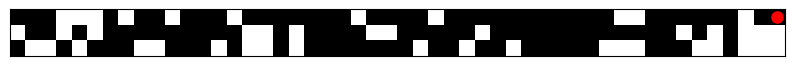

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_path(grid, path):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_xticks([])
    ax.set_yticks([])
    
    grid_display = np.copy(grid)
    grid_display[grid_display == 1] = -1  
    img = ax.imshow(grid_display, cmap='gray_r', origin='upper')
    
    agent_marker, = ax.plot([], [], 'ro', markersize=8)  
    
    def update(frame):
        row, col = path[frame]
        agent_marker.set_data([col], [row])  
        return agent_marker,
    
    ani = animation.FuncAnimation(fig, update, frames=len(path), interval=200, repeat=False)
    
    return HTML(ani.to_jshtml())
animate_path(grid, path)


# **Question04**

In [30]:
import random
import numpy as np

attractions=[
    {"id": 1, "name": "Badshahi Mosque", "cost": 10, "popularity": 9, "duration": 2},
    {"id": 2, "name": "Lahore Fort", "cost": 15, "popularity": 9, "duration": 3},
    {"id": 3, "name": "Shalimar Gardens", "cost": 5, "popularity": 8, "duration": 2},
    {"id": 4, "name": "Minar-e-Pakistan", "cost": 0, "popularity": 7, "duration": 1},
    {"id": 5, "name": "Wagah Border", "cost": 0, "popularity": 8, "duration": 3},
    {"id": 6, "name": "Lahore Museum", "cost": 5, "popularity": 7, "duration": 2},
    {"id": 7, "name": "Anarkali Bazaar", "cost": 0, "popularity": 6, "duration": 2},
    {"id": 8, "name": "Jahangir's Tomb", "cost": 10, "popularity": 7, "duration": 2},
    {"id": 9, "name": "Sheesh Mahal", "cost": 5, "popularity": 8, "duration": 1},
    {"id": 10, "name": "Food Street Gawalmandi", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 11, "name": "Hiran Minar", "cost": 10, "popularity": 7, "duration": 2},
    {"id": 12, "name": "Shahi Hammam", "cost": 5, "popularity": 6, "duration": 1},
    {"id": 13, "name": "Grand Jamia Mosque", "cost": 0, "popularity": 8, "duration": 2},
    {"id": 14, "name": "Emporium Mall", "cost": 0, "popularity": 9, "duration": 3},
    {"id": 15, "name": "Liberty Market", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 16, "name": "MM Alam Road", "cost": 0, "popularity": 8, "duration": 2},
    {"id": 17, "name": "Fortress Square", "cost": 0, "popularity": 7, "duration": 3},
    {"id": 18, "name": "Gaddafi Stadium", "cost": 5, "popularity": 8, "duration": 3},
    {"id": 19, "name": "Lahore Zoo", "cost": 5, "popularity": 8, "duration": 2},
    {"id": 20, "name": "Racecourse Park", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 21, "name": "Jilani Park", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 22, "name": "Model Town Park", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 23, "name": "Gulshan-e-Iqbal Park", "cost": 0, "popularity": 6, "duration": 2},
    {"id": 24, "name": "Chhanga Manga Forest", "cost": 10, "popularity": 7, "duration": 3},
    {"id": 25, "name": "Joyland Lahore", "cost": 15, "popularity": 8, "duration": 3},
    {"id": 26, "name": "Sozo Water Park", "cost": 20, "popularity": 7, "duration": 4},
    {"id": 27, "name": "Safari Park", "cost": 10, "popularity": 6, "duration": 3},
    {"id": 28, "name": "Jallo Park", "cost": 5, "popularity": 6, "duration": 3},
    {"id": 29, "name": "Bagh-e-Jinnah", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 30, "name": "Shaukat Khanum Hospital", "cost": 0, "popularity": 6, "duration": 1},
    {"id": 31, "name": "University of Punjab", "cost": 0, "popularity": 6, "duration": 2},
    {"id": 32, "name": "Government College University", "cost": 0, "popularity": 6, "duration": 2},
    {"id": 33, "name": "Mall Road", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 34, "name": "Tomb of Noor Jahan", "cost": 5, "popularity": 7, "duration": 2},
    {"id": 35, "name": "Moti Masjid", "cost": 5, "popularity": 6, "duration": 1},
    {"id": 36, "name": "Data Darbar", "cost": 0, "popularity": 8, "duration": 2},
    {"id": 37, "name": "Wazir Khan Mosque", "cost": 5, "popularity": 8, "duration": 2},
    {"id": 38, "name": "The National History Museum", "cost": 10, "popularity": 7, "duration": 2},
    {"id": 39, "name": "Pakistan Railway Heritage Museum", "cost": 10, "popularity": 6, "duration": 2},
    {"id": 40, "name": "Alhamra Arts Council", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 41, "name": "Hazuri Bagh", "cost": 5, "popularity": 7, "duration": 1},
    {"id": 42, "name": "Iqbal Park", "cost": 0, "popularity": 8, "duration": 2},
    {"id": 43, "name": "Sheikhupura Fort", "cost": 15, "popularity": 7, "duration": 3},
    {"id": 44, "name": "Chughtai Museum", "cost": 5, "popularity": 6, "duration": 2},
    {"id": 45, "name": "Bahria Town Eiffel Tower", "cost": 10, "popularity": 7, "duration": 2},
    {"id": 46, "name": "Lahore Canal", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 47, "name": "Pak Tea House", "cost": 0, "popularity": 6, "duration": 2},
    {"id": 48, "name": "DHA Y Block Market", "cost": 0, "popularity": 7, "duration": 2},
    {"id": 49, "name": "The Mall of Lahore", "cost": 0, "popularity": 8, "duration": 3},
    {"id": 50, "name": "Lake City Lahore", "cost": 10, "popularity": 7, "duration": 3}
]

def generate_travel_matrix(size, min_time=0.2, max_time=3.0):
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i + 1, size):
            time = round(random.uniform(min_time, max_time), 1)
            matrix[i][j] = time
            matrix[j][i] = time
    return matrix

size = 50
travel_time = generate_travel_matrix(size)

In [19]:
num_days = 5
max_hours_per_day = 8
max_attractions_per_day = 10
population_size = 100
num_generations = 100
mutation_rate = 0.1
tournament_size = 5


In [24]:
def create_individual():
    all_ids = list(range(50))
    random.shuffle(all_ids)
    itinerary = [[] for _ in range(num_days)]
    used = set()
    for day in range(num_days):
        total_time = 0
        for attr_id in all_ids:
            if attr_id not in used:
                time_needed = attractions[attr_id]["duration"]
                if itinerary[day]:
                    time_needed += travel_time[itinerary[day][-1]][attr_id]
                if total_time + time_needed <= max_hours_per_day and len(itinerary[day]) < max_attractions_per_day:
                    itinerary[day].append(attr_id)
                    total_time += time_needed
                    used.add(attr_id)
    return itinerary


In [25]:
def calculate_fitness(itinerary):
    total_popularity = 0
    total_cost = 0
    penalty = 0
    for day in itinerary:
        daily_time = 0
        if len(day) > max_attractions_per_day:
            penalty += 1000 * (len(day) - max_attractions_per_day)
        for i, attr_id in enumerate(day):
            total_popularity += attractions[attr_id]["popularity"]
            total_cost += attractions[attr_id]["cost"]
            daily_time += attractions[attr_id]["duration"]
            if i > 0:
                daily_time += travel_time[day[i-1]][attr_id]
        if daily_time > max_hours_per_day:
            penalty += 1000 * (daily_time - max_hours_per_day)
    used_attractions = set()
    for day in itinerary:
        for attr_id in day:
            if attr_id in used_attractions:
                penalty += 10000
            used_attractions.add(attr_id)
    fitness = total_popularity - total_cost - penalty
    return fitness, total_popularity, total_cost


In [26]:
def tournament_selection(population):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: calculate_fitness(x)[0])

In [27]:
def crossover(parent1, parent2):
    child = [[] for _ in range(num_days)]
    used = set()
    for day in range(num_days):
        source = parent1[day] if random.random() < 0.5 else parent2[day]
        total_time = 0
        for attr_id in source:
            time_needed = attractions[attr_id]["duration"]
            if child[day]:
                time_needed += travel_time[child[day][-1]][attr_id]
            if total_time + time_needed <= max_hours_per_day and len(child[day]) < max_attractions_per_day and attr_id not in used:
                child[day].append(attr_id)
                total_time += time_needed
                used.add(attr_id)
    remaining = set(range(50)) - used
    remaining = list(remaining)
    random.shuffle(remaining)
    for day in range(num_days):
        total_time = sum(attractions[i]["duration"] for i in child[day]) + (sum(travel_time[child[day][i]][child[day][i+1]] for i in range(len(child[day])-1)) if len(child[day]) > 1 else 0)
        for attr_id in remaining[:]:
            time_needed = attractions[attr_id]["duration"]
            if child[day]:
                time_needed += travel_time[child[day][-1]][attr_id]
            if total_time + time_needed <= max_hours_per_day and len(child[day]) < max_attractions_per_day:
                child[day].append(attr_id)
                total_time += time_needed
                remaining.remove(attr_id)
    return child


In [28]:
def mutation(itinerary):
    if random.random() < mutation_rate:
        day1, day2 = random.sample(range(num_days), 2)
        if itinerary[day1] and itinerary[day2]:
            idx1 = random.randint(0, len(itinerary[day1]) - 1)
            idx2 = random.randint(0, len(itinerary[day2]) - 1)
            itinerary[day1][idx1], itinerary[day2][idx2] = itinerary[day2][idx2], itinerary[day1][idx1]
    return itinerary

In [31]:
population = [create_individual() for _ in range(population_size)]
for generation in range(num_generations):
    new_population = []
    for _ in range(population_size // 2):
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)
        child1 = crossover(parent1, parent2)
        child2 = crossover(parent2, parent1)
        child1 = mutation(child1)
        child2 = mutation(child2)
        new_population.extend([child1, child2])
    population = new_population
    if generation % 25 == 0:
        best = max(population, key=lambda x: calculate_fitness(x)[0])
        fitness, popularity, cost = calculate_fitness(best)
        print(f"generation {generation}: fitness = {fitness}, popularity = {popularity}, cost = {cost}")

best_itinerary = max(population, key=lambda x: calculate_fitness(x)[0])
fitness, total_popularity, total_cost = calculate_fitness(best_itinerary)

print("\noptimal 5-day itinerary:")
for day, plan in enumerate(best_itinerary, 1):
    daily_time = sum(attractions[i]["duration"] for i in plan) + (sum(travel_time[plan[i]][plan[i+1]] for i in range(len(plan)-1)) if len(plan) > 1 else 0)
    print(f"day {day} (total time: {daily_time:.1f} hours):")
    for i, attr_id in enumerate(plan):
        attr = attractions[attr_id]
        travel = travel_time[plan[i-1]][attr_id] if i > 0 else 0
        print(f"  {i+1}. {attr['name']} - popularity: {attr['popularity']}, cost: ${attr['cost']}, duration: {attr['duration']}h, travel time: {travel:.1f}h")
print(f"total enjoyment score: {total_popularity}")
print(f"total cost: ${total_cost}")


generation 0: fitness = 83, popularity = 98, cost = 15
generation 25: fitness = 110, popularity = 115, cost = 5
generation 50: fitness = 110, popularity = 115, cost = 5
generation 75: fitness = 110, popularity = 115, cost = 5

optimal 5-day itinerary:
day 1 (total time: 7.0 hours):
  1. Government College University - popularity: 6, cost: $0, duration: 2h, travel time: 0.0h
  2. Bagh-e-Jinnah - popularity: 7, cost: $0, duration: 2h, travel time: 1.5h
  3. Shaukat Khanum Hospital - popularity: 6, cost: $0, duration: 1h, travel time: 0.5h
day 2 (total time: 7.2 hours):
  1. Alhamra Arts Council - popularity: 7, cost: $0, duration: 2h, travel time: 0.0h
  2. DHA Y Block Market - popularity: 7, cost: $0, duration: 2h, travel time: 0.9h
  3. Iqbal Park - popularity: 8, cost: $0, duration: 2h, travel time: 0.3h
day 3 (total time: 7.5 hours):
  1. Racecourse Park - popularity: 7, cost: $0, duration: 2h, travel time: 0.0h
  2. Data Darbar - popularity: 8, cost: $0, duration: 2h, travel time: 0